<img src="https://certificate.tpq.io/taim_logo.png" width="350px" align="right">

# Artificial Intelligence in Finance

## Dense Neural Networks

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('display.precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

## The Data

In [2]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [3]:
symbol = 'EUR_USD'

In [4]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)

In [5]:
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [7]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]

In [8]:
data = data.resample('1h', label='right').last().ffill()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 01:00:00 to 2020-01-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


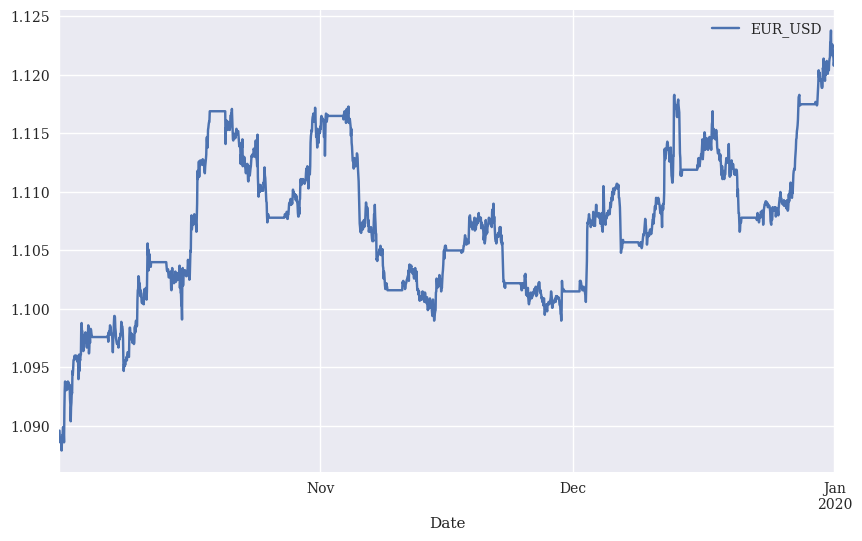

In [10]:
data.plot(figsize=(10, 6));

## Baseline Prediction

In [11]:
lags = 5

In [12]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [13]:
data, cols = add_lags(data, symbol, lags)

In [14]:
len(data)

2183

In [15]:
# data.iloc[:10, :14].round(4)

In [16]:
c = data['d'].value_counts()
c

d
0    1445
1     738
Name: count, dtype: int64

In [17]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [18]:
class_weight = cw(data)

In [19]:
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [20]:
class_weight[0] * c[0]

1091.5

In [21]:
class_weight[1] * c[1]

1091.5

In [22]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [23]:
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import accuracy_score

In [24]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [25]:
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)

In [26]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [27]:
set_seeds()
model = create_model(hl=1, hu=128)

In [28]:
%%time
model.fit(data[cols], data['d'], epochs=50,
          verbose=False, class_weight=cw(data))

CPU times: user 2.5 s, sys: 737 ms, total: 3.23 s
Wall time: 2.16 s


In [29]:
model.evaluate(data[cols], data['d'])

69/69 [==============================] - 0s 433us/step - loss: 0.6016 - accuracy: 0.5754


[0.6016420722007751, 0.5753549933433533]

In [30]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)

69/69 [==============================] - 0s 355us/step


In [31]:
data['p'].value_counts()

p
1    1585
0     598
Name: count, dtype: int64

In [32]:
split = int(len(data) * 0.8)

In [33]:
train = data.iloc[:split].copy()

In [34]:
test = data.iloc[split:].copy()

In [35]:
set_seeds()
model = create_model(hl=1, hu=128)

In [36]:
%%time 
hist = model.fit(train[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 2.42 s, sys: 634 ms, total: 3.05 s
Wall time: 2.16 s


In [37]:
model.evaluate(train[cols], train['d'])

55/55 [==============================] - 0s 397us/step - loss: 0.6115 - accuracy: 0.5934


[0.6115062832832336, 0.5933562517166138]

In [38]:
model.evaluate(test[cols], test['d'])

14/14 [==============================] - 0s 473us/step - loss: 0.5958 - accuracy: 0.6133


[0.5957705974578857, 0.6132723093032837]

In [39]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)

14/14 [==============================] - 0s 439us/step


In [40]:
test['p'].value_counts()

p
1    284
0    153
Name: count, dtype: int64

In [41]:
res = pd.DataFrame(hist.history)

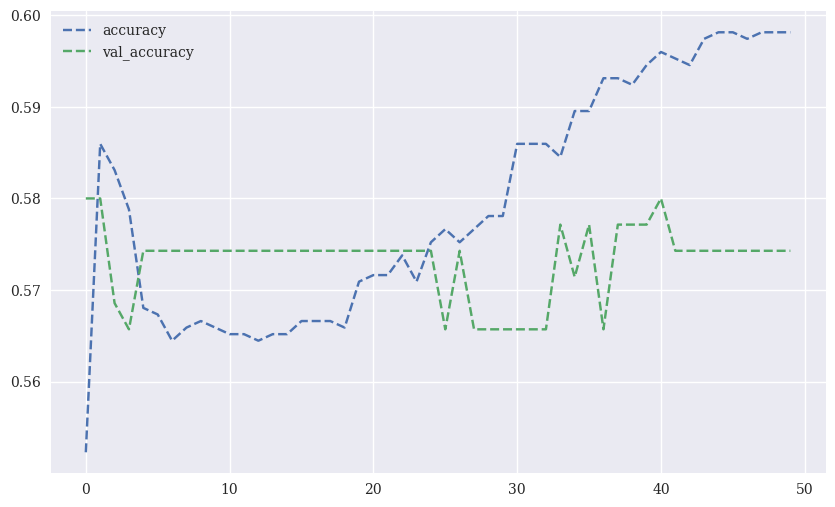

In [42]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Normalization

In [43]:
mu, std = train.mean(), train.std()

In [44]:
train_ = (train - mu) / std

In [45]:
# train_.std().round(3)

In [46]:
set_seeds()
model = create_model(hl=2, hu=128)

In [47]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 2.7 s, sys: 769 ms, total: 3.46 s
Wall time: 2.37 s


In [48]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 429us/step - loss: 0.4824 - accuracy: 0.9003


[0.4823555648326874, 0.900343656539917]

In [49]:
test_ = (test - mu) / std

In [50]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 483us/step - loss: 1.5019 - accuracy: 0.6453


[1.5019252300262451, 0.6453089118003845]

In [51]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

14/14 [==============================] - 0s 477us/step


In [52]:
test['p'].value_counts()

p
0    265
1    172
Name: count, dtype: int64

In [53]:
res = pd.DataFrame(hist.history)

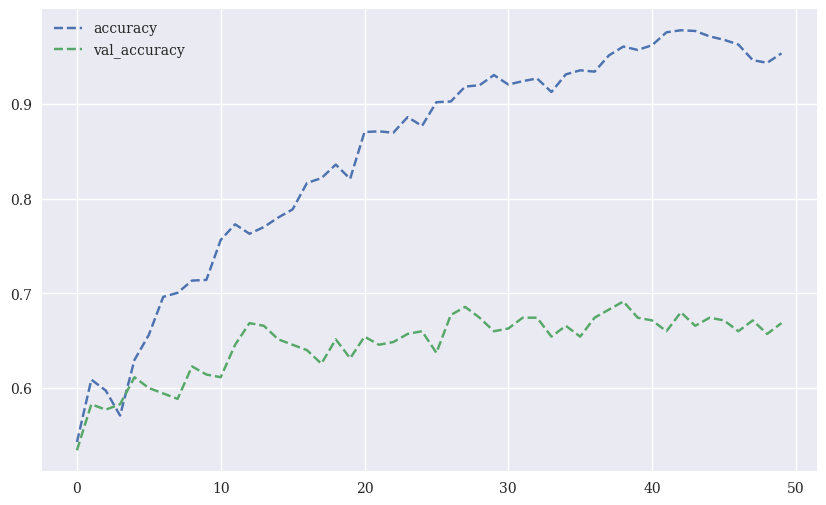

In [54]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Dropout 

In [55]:
from keras.layers import Dropout

In [56]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3,
                 optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [57]:
set_seeds()
model = create_model(hl=1, hu=128, rate=0.3)

In [58]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.15, shuffle=False,
          class_weight=cw(train))

CPU times: user 2.61 s, sys: 651 ms, total: 3.27 s
Wall time: 2.34 s


In [59]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 416us/step - loss: 0.4440 - accuracy: 0.7881


[0.4439946711063385, 0.7880870699882507]

In [60]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 484us/step - loss: 0.5874 - accuracy: 0.6568


[0.5874191522598267, 0.6567505598068237]

In [61]:
res = pd.DataFrame(hist.history)

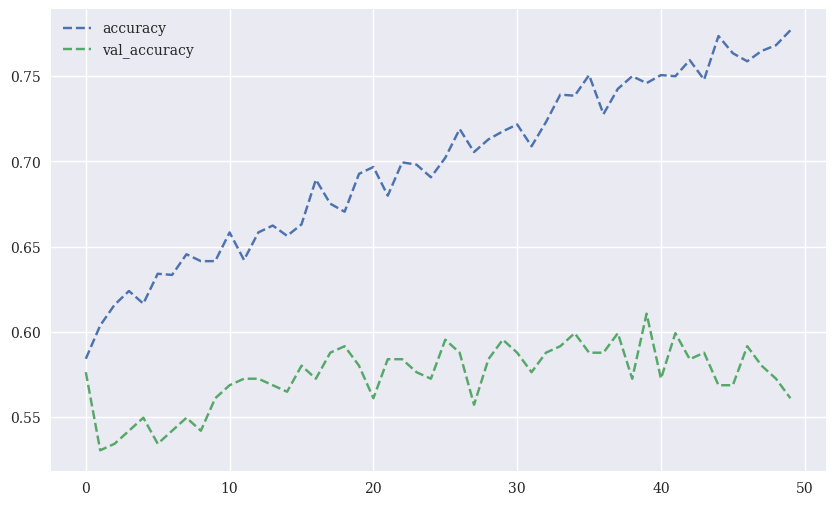

In [62]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

## Regularization 

In [63]:
from keras.regularizers import l1, l2

In [64]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3, 
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [65]:
set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

In [66]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 2.46 s, sys: 650 ms, total: 3.11 s
Wall time: 2.18 s


In [67]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 419us/step - loss: 0.3629 - accuracy: 0.8769


[0.36286449432373047, 0.8768613934516907]

In [68]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 484us/step - loss: 1.0080 - accuracy: 0.5789


[1.008002758026123, 0.5789473652839661]

In [69]:
res = pd.DataFrame(hist.history)

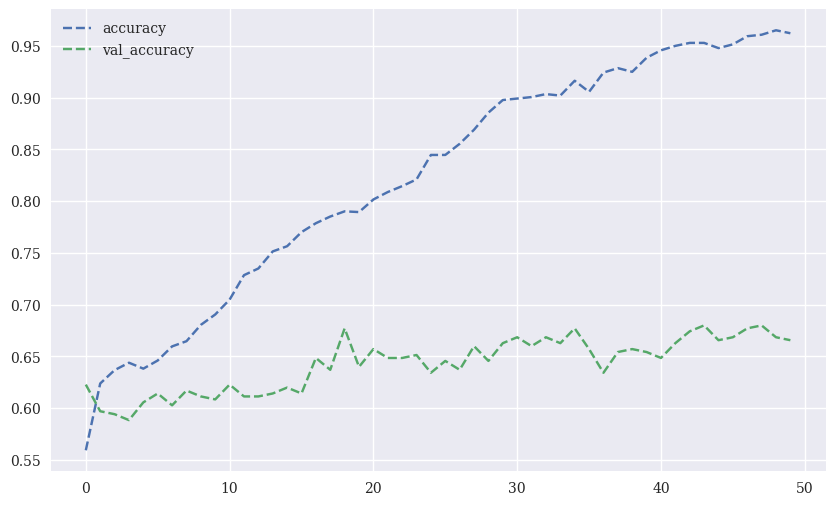

In [70]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [71]:
set_seeds()
model = create_model(hl=2, hu=128,
                     dropout=True, rate=0.3,
                     regularize=True, reg=l2(0.001),
                    )

In [72]:
%%time 
hist = model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 3.07 s, sys: 798 ms, total: 3.87 s
Wall time: 2.73 s


In [73]:
model.evaluate(train_[cols], train['d'])

55/55 [==============================] - 0s 428us/step - loss: 0.4532 - accuracy: 0.7904


[0.4531913101673126, 0.7903780341148376]

In [74]:
model.evaluate(test_[cols], test['d'])

14/14 [==============================] - 0s 943us/step - loss: 0.5818 - accuracy: 0.6590


[0.5818382501602173, 0.6590389013290405]

In [75]:
res = pd.DataFrame(hist.history)

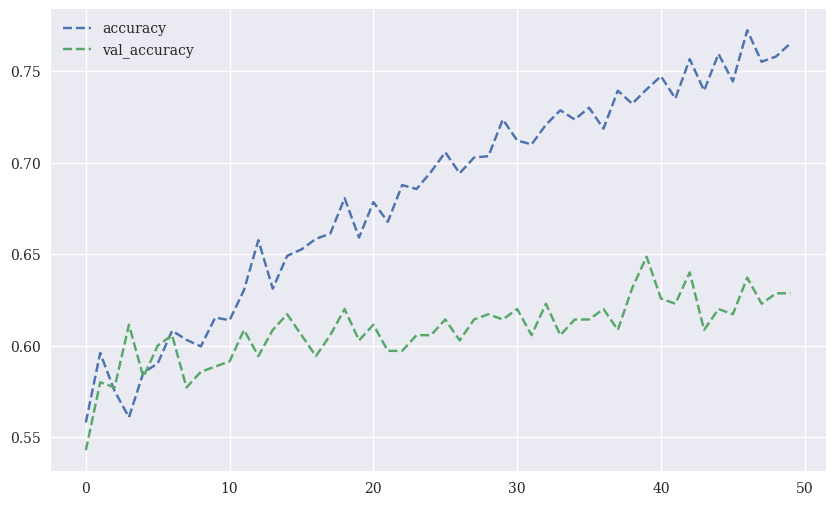

In [76]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [77]:
res.mean()['accuracy'] - res.mean()['val_accuracy']

0.07383512258529656

## Bagging

In [78]:
from sklearn.ensemble import BaggingClassifier
# from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

In [79]:
len(cols)

40

In [80]:
max_features = 0.75

In [81]:
set_seeds()
base_estimator = KerasClassifier(model=create_model,
                        verbose=False, epochs=20, hl=1, hu=128,
                        dropout=True, regularize=False,
                        input_dim=int(len(cols) * max_features))

In [82]:
model_bag = BaggingClassifier(estimator=base_estimator,
                          n_estimators=15,
                          max_samples=0.75,
                          max_features=max_features,
                          bootstrap=True,
                          bootstrap_features=True,
                          n_jobs=1,
                          random_state=100,
                         )

In [83]:
%time model_bag.fit(train_[cols], train['d'])

CPU times: user 10.6 s, sys: 1.93 s, total: 12.5 s
Wall time: 9.62 s


BaggingClassifier(bootstrap_features=True,
                  estimator=KerasClassifier(dropout=True, epochs=20, hl=1, hu=128, input_dim=30, model=<function create_model at 0x17fe3e710>, regularize=False, verbose=False),
                  max_features=0.75, max_samples=0.75, n_estimators=15,
                  n_jobs=1, random_state=100)

In [84]:
model_bag.score(train_[cols], train['d'])

0.7290950744558992

In [85]:
model_bag.score(test_[cols], test['d'])

0.6681922196796338

In [86]:
test['p'] = model_bag.predict(test_[cols])

In [87]:
test['p'].value_counts()

p
0    403
1     34
Name: count, dtype: int64

## Optimizers

In [88]:
import time

In [89]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
              'adam', 'adamax', 'nadam']

In [90]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128,
                     dropout=True, rate=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer
                    )
    t0 = time.time()
    model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 1.9997 | in-sample=0.6346 | out-of-sample=0.6728
rmsprop    | time[s]: 2.1066 | in-sample=0.7692 | out-of-sample=0.6453
adagrad    | time[s]: 2.0495 | in-sample=0.6254 | out-of-sample=0.6613
adadelta   | time[s]: 2.2592 | in-sample=0.3396 | out-of-sample=0.3501
adam       | time[s]: 2.1956 | in-sample=0.7709 | out-of-sample=0.6636
adamax     | time[s]: 2.1825 | in-sample=0.6770 | out-of-sample=0.6293
nadam      | time[s]: 2.3478 | in-sample=0.7921 | out-of-sample=0.6659
CPU times: user 17.5 s, sys: 2.55 s, total: 20.1 s
Wall time: 15.8 s


In [91]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

14/14 [==============================] - 0s 463us/step


In [92]:
test['p'].value_counts()

p
0    294
1    143
Name: count, dtype: int64

In [93]:
accuracy_score(test['p'], test['d'])

0.665903890160183

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>